In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2439, 4)
torch.Size([1931, 10, 4])


4

In [4]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [5]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)  # 新增的線性層
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, feature_size)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src 形狀: (seq_length, batch_size, feature_size)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)  # 將輸入映射到 hidden_dim 維度
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        
        output = output[-10:, :, :]  # 取最後 10 個時間步
        output = self.decoder(output)  # 映射到 feature_size
        output = output.permute(1, 0, 2)
        return output

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [7]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "transformer_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Model saved with val_loss: 0.0543
Epoch [1/100], Train Loss: 0.0338, Val Loss: 0.0543
Model saved with val_loss: 0.0364
Epoch [2/100], Train Loss: 0.0579, Val Loss: 0.0364
Model saved with val_loss: 0.0092
Epoch [3/100], Train Loss: 0.0336, Val Loss: 0.0092
Model saved with val_loss: 0.0033
Epoch [4/100], Train Loss: 0.0103, Val Loss: 0.0033
Model saved with val_loss: 0.0026
Epoch [5/100], Train Loss: 0.0082, Val Loss: 0.0026
Model saved with val_loss: 0.0020
Epoch [6/100], Train Loss: 0.0070, Val Loss: 0.0020
Model saved with val_loss: 0.0019
Epoch [7/100], Train Loss: 0.0063, Val Loss: 0.0019
Epoch [8/100], Train Loss: 0.0057, Val Loss: 0.0019
Model saved with val_loss: 0.0018
Epoch [9/100], Train Loss: 0.0053, Val Loss: 0.0018
Epoch [10/100], Train Loss: 0.0049, Val Loss: 0.0018
Model saved with val_loss: 0.0016
Epoch [11/100], Train Loss: 0.0046, Val Loss: 0.0016
Model saved with val_loss: 0.0015
Epoch [12/100], Train Loss: 0.0044, Val Loss: 0.0015
Model saved with val_loss: 0.0014

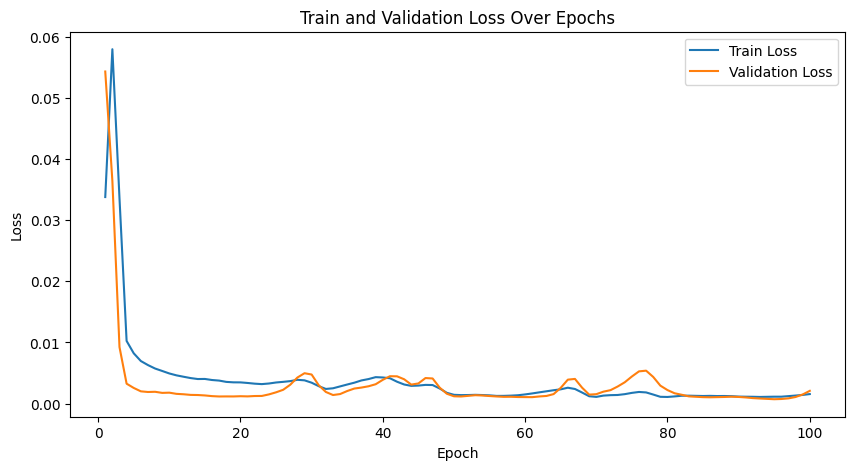

In [8]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

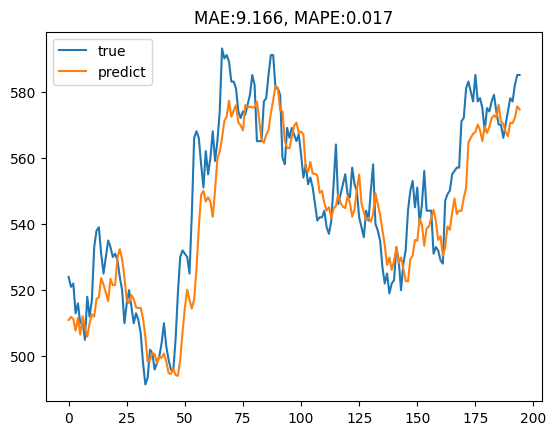

In [9]:
import matplotlib.pyplot as plt
close_price_true = []
close_price_pred = []
model = torch.load('transformer_10.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device)).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [10]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
print("mape: ", mape)
print("mae: ", mae)

(195, 10)
(195, 10)
mape:  0.02419272151084504
mae:  13.266235821598615


In [9]:
ma10_f=[]
true=[]
pred=[]
for i in range(0,len(close_price_pred)):
    true.append(round(close_price_true[i][0]))
    ma10_f.append(np.mean(close_price_pred[i]))
    pred.append(close_price_pred[i][0])

newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524,512.314004,515.867583
1,521,510.716863,517.753026
2,522,511.868828,519.279405
3,513,511.082913,521.791446
4,516,517.868844,522.553047
...,...,...,...
190,578,571.771396,575.139759
191,577,576.325475,577.253321
192,582,577.923762,577.913367
193,585,579.117703,579.286660


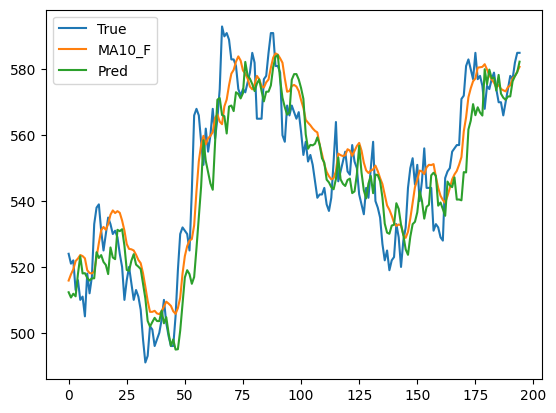

In [10]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [11]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 487000 1
5 487000 0
6 487000 0
7 487000 0
8 487000 0
9 487000 0
10 487000 0
11 487000 0
12 1020000 -1
13 1020000 0
14 1020000 0
15 489000 1
16 489000 0
17 489000 0
18 489000 0
19 489000 0
20 489000 0
21 489000 0
22 489000 0
23 489000 0
24 489000 0
25 489000 0
26 489000 0
27 489000 0
28 489000 0
29 489000 0
30 489000 0
31 489000 0
32 489000 0
33 489000 0
34 489000 0
35 489000 0
36 489000 0
37 489000 0
38 489000 0
39 489000 0
40 489000 0
41 489000 0
42 999000 -1
43 496000 1
44 496000 0
45 496000 0
46 496000 0
47 496000 0
48 1015000 -1
49 1015000 0
50 1015000 0
51 1015000 0
52 1015000 0
53 490000 1
54 1033000 -1
55 1033000 0
56 1033000 0
57 1033000 0
58 475000 1
59 475000 0
60 1037000 -1
61 482000 1
62 482000 0
63 1050000 -1
64 491000 1
65 1056000 -1
66 1056000 0
67 1056000 0
68 1056000 0
69 1056000 0
70 1056000 0
71 1056000 0
72 1056000 0
73 475000 1
74 475000 0
75 475000 0
76 475000 0
77 475000 0
78 1051000 -1
79 1051000 0
80 1051000 0
81 1051000 0


In [12]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 487000 1
5 487000 0
6 487000 0
7 487000 0
8 487000 0
9 1005000 -1
10 493000 1
11 1010000 -1
12 1010000 0
13 1010000 0
14 1010000 0
15 1010000 0
16 1010000 0
17 1010000 0
18 1010000 0
19 1010000 0
20 1010000 0
21 479000 1
22 479000 0
23 479000 0
24 479000 0
25 479000 0
26 479000 0
27 479000 0
28 479000 0
29 479000 0
30 479000 0
31 479000 0
32 479000 0
33 479000 0
34 479000 0
35 479000 0
36 479000 0
37 479000 0
38 479000 0
39 479000 0
40 479000 0
41 983000 -1
42 983000 0
43 983000 0
44 983000 0
45 487000 1
46 983000 -1
47 983000 0
48 983000 0
49 983000 0
50 983000 0
51 983000 0
52 983000 0
53 983000 0
54 983000 0
55 983000 0
56 983000 0
57 983000 0
58 425000 1
59 425000 0
60 987000 -1
61 987000 0
62 987000 0
63 987000 0
64 428000 1
65 428000 0
66 1002000 -1
67 1002000 0
68 1002000 0
69 1002000 0
70 1002000 0
71 1002000 0
72 1002000 0
73 1002000 0
74 1002000 0
75 430000 1
76 430000 0
77 430000 0
78 430000 0
79 1009000 -1
80 1009000 0
81 1009000 0
82 4

In [11]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x, y = test_set[i]
    x = torch.unsqueeze(x, 0)
    y = torch.unsqueeze(y, 0)
    pred = model(x.to(device))
    
    # 取第十天的真實值和預測值
    y_tenth_day = torch.squeeze(y)[9]  # 第 10 天對應索引為 9
    pred_tenth_day = torch.squeeze(pred.detach().cpu())[9]
    
    # 反轉換
    true_tenth_day = scaler.inverse_transform(y_tenth_day.unsqueeze(0))[:, dim]
    pred_tenth_day = scaler.inverse_transform(pred_tenth_day.unsqueeze(0))[:, dim]
    
    # 儲存第十天的值
    close_price_true.append(true_tenth_day)
    close_price_pred.append(pred_tenth_day)

# 將結果轉換為 NumPy 陣列
close_price_true = np.array(close_price_true).squeeze()
close_price_pred = np.array(close_price_pred).squeeze()

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)

# 計算 MAE 和 MAPE
mape = np.mean(np.abs(close_price_true - close_price_pred) / close_price_true)
mae = np.mean(np.abs(close_price_true - close_price_pred))

print("第十天的 mape: ", mape)
print("第十天的 mae: ", mae)


(195,)
(195,)
第十天的 mape:  0.03015429431251567
第十天的 mae:  16.521220914828472


In [9]:
import csv

with open('ex2output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('ex2output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

